In [1]:
%matplotlib inline

import os
import glob
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import seaborn as sns 
import matplotlib.pyplot as plt
import time 
import datetime
import pickle

from scipy.stats import zscore 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests

In [29]:
# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

In [2]:
pfp = '/home/ngr4/project/collabs/grants/czi_rp_2103/results/'
with open('/home/ngr4/project/collabs/grants/czi_rp_2103/data/processed/rpczi.pkl', 'rb') as f:
    temp = pickle.load(f)
    f.close()
adata = temp['adata']

In [3]:
adata

AnnData object with n_obs × n_vars = 70386 × 26507
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'age', 'sex', 'donor', 'batch', 'celltype', 'lineage', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'pmito', 'source', 'n_counts_all', 'n_counts', 'age_in_wk', 'age_rangescaled', 'Age (MELD)'
    var: 'gene_ids-CPB', 'feature_types-CPB', 'n_cells_by_counts-CPB', 'mean_counts-CPB', 'log1p_mean_counts-CPB', 'pct_dropout_by_counts-CPB', 'total_counts-CPB', 'log1p_total_counts-CPB', 'n_counts', 'mean', 'std'
    uns: 'log1p'

... storing 'orig.ident' as categorical
... storing 'age' as categorical
... storing 'sex' as categorical
... storing 'donor' as categorical
... storing 'batch' as categorical
... storing 'celltype' as categorical
... storing 'lineage' as categorical


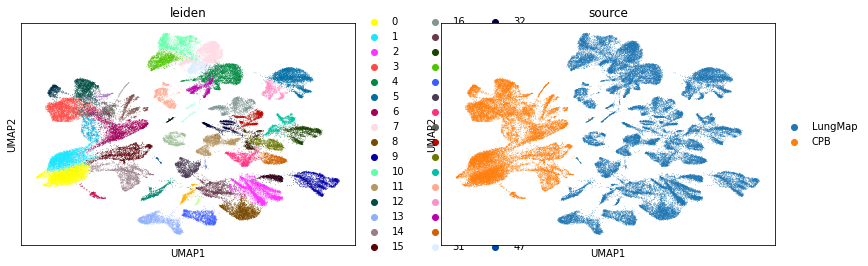

In [4]:
# sc.pp.combat(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden', 'source'])

In [5]:
# define markers & cell types
## TODO (before final polishes): add canonical cell type markers for human lung from Table S1 https://www.biorxiv.org/content/10.1101/742320v2.full.pdf
## REF: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5135277/ (most lung tissue markers come from here)
cell_markers = {'Basal': ['KRT5', 'DAPL1', 'TP63'],
                'Basal (proliferating)': ['ADH7', 'MKI67', 'TOP2A', 'CDK1'],
                'Hillock': ['KRT4', 'KRT13'],
                'Club': [ 'KRT15', 'CD74','CXCL6'],
                'Ciliated': ['FOXJ1', 'CCDC153', 'CCDC113', 'MLF1', 'LZTFL1','TUBB1','TP73','CCDC78'],
                'Tuft': ['POU2F3', 'AVIL', 'MAFF','MIAT','NOS2'],
                'Ionocyte': ['FOXI1', 'CFTR',], # 'ASCL3' not found
                'Goblet': ['MUC5AC', 'MUC5B', 'SPDEF'],
                'Epithelial':['ABCA3','LPCAT1','NAPSA','SFTPB','SFTPC','SLC34A2'],
                'Neuroendocrine':['ACADSB','ADA','AFAP1','CPE'],
                'Dendritic':['ITGAX','CCR7','CD1A','CD207'], # 'LY75' not found
#                 'Macrophage':['CD68','CD14','CCL18','CD163'],
                'Endothelial':['CD34','PECAM1','VWF'],
                'Fibroblast':['THY1','CD36','PDGFRA','PTPN13'],
                'Tcell':['CD3E','CD3D','CD3G','CD8A','CD8B','CD4'],
                'Granulocyte':['CCR5','SMAD1','ITGAM'],
#                 'Alveolar':['SLC34A2','ABCA3','CD44'],
                'AT1':['SLC34A2','ABCA3','CD44','AGER','PDPN','CLIC5'],
                'AT2':['SLC34A2','ABCA3','CD44','SFTPB','SFTPC','SFTPD','MUC1'],
                'Myofibroblast':['ACTA2'],
                'Monocyte':['CD36','CD14','CD68'],
                'NK':['NCR1'],
                'Progenitor':['TM4SF1','CEACAM6'],
#                 'Neutrophil':['S100A9','S100A8','S100A12','VCAN','FCN1',
#                               'CSTA','TSPO','CD14','MNDA','CTSD','PLBD1'], # from Tianyang (Iwasaki lab) ORIGINAL
                # updated 051820
                'Eosinophil':['RNASE2','LGALS1','RETN','AC020656.1', # 'RNASE3' not found
                              'H1FX','SLC44A1','AL355922.1','RFLNB','SERPINB10'], # from Tianyang (Iwasaki lab) ORIGINAL
#                 'Macrophage':['S100A9','S100A8','FCGR3A','CD14','CD68','FCGR1A','MARCO','MSR1','MRC1','C1QB','C1QA','FABP4','APOC1','APOE','PPARG'],
#                 'Monocyte':['S100A9','S100A8','FCGR3A','CD14','CD68','FCGR1A','RNASE2','RNASE3','FCN1','TNFRSF1B','S100A12','VCAN','CCR2','SDS'],
#                 'Monocyte':['CCR2', 'FCN1', 'RNASE2', 'RNASE3', 'S100A12', 'SDS', 'TNFRSF1B', 'VCAN'], # no overlap btw Macrophage/Monocyte/Neutrophil
                'Monocyte':['CCR2', 'FCN1', 'RNASE2', 'S100A12', 'SDS', 'TNFRSF1B', 'VCAN'],
                'Macrophage':['APOC1', 'APOE', 'C1QA', 'C1QB', 'FABP4', 'MARCO', 'MRC1', 'MSR1', 'PPARG'], # no overlap btw Macrophage/Monocyte/Neutrophil
                'Neutrophil':['CEACAM1', 'CEACAM8', 'CSF3R', 'CXCR1', 'CXCR2', 'FCGR3B'], # no overlap btw Macrophage/Monocyte/Neutrophil
#                 'Neutrophil':['S100A9','S100A8','FCGR3A','CEACAM8','CXCR1','CXCR2','CEACAM1','FCGR3B','CSF3R'],
#                 'Eosinophil':['RNASE2','RNASE3','IL5RA','CCR3','EPX','PRG2','PRG3','PTGDR2','SIGLEC8','GATA2'], # don't use RNASE2/3 since they overlap
#                 'Eosinophil':['IL5RA','CCR3','PRG2','PTGDR2','SIGLEC8','GATA2'], # don't use RNASE2/3 since they overlap
#                 'Eosinophil':['IL5RA','CCR3','PRG2','PTGDR2','SIGLEC8','GATA2', 'EPO','CD9','RNASE3','RETN','H1FX','RFLNB'], # added EPO and CD9 <>                
               }


# subset data to markers
genes = [g for k,v in cell_markers.items() for g in v]
x = pd.DataFrame(adata[:,genes].X, columns=genes)
x['cluster'] = adata.obs['leiden'].to_list()
add_pcs = True
if add_pcs:
    # add PCs?
    pcs = ['PC1','PC2']
    for i,pc in enumerate(pcs):       
        x[pc] = adata.obsm['X_pca'][:,i]
    genes = genes + pcs

# standard scale
x.loc[:,genes] = zscore(x.loc[:,genes])

/gpfs/ycga/project/dijk/ngr4/conda_envs/rnavel/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Lasso logistic regression
  through 4.3-% in 93.71-s	~2065.48-s remain
  through 8.7-% in 231.10-s	~2431.13-s remain
  through 13.0-% in 332.81-s	~2223.15-s remain
  through 17.4-% in 462.61-s	~2202.05-s remain
  through 21.7-% in 639.10-s	~2305.86-s remain
  through 26.0-% in 754.82-s	~2143.70-s remain
  through 30.4-% in 840.39-s	~1925.70-s remain
  through 34.7-% in 982.53-s	~1847.16-s remain
  through 39.1-% in 1354.74-s	~2113.39-s remain
  through 43.4-% in 1466.75-s	~1912.64-s remain
  through 47.7-% in 1575.57-s	~1724.53-s remain
  through 52.1-% in 1683.46-s	~1548.78-s remain
  through 56.4-% in 1813.63-s	~1400.68-s remain
  through 60.8-% in 1935.57-s	~1249.82-s remain
  through 65.1-% in 2092.03-s	~1121.33-s remain
  through 69.4-% in 2456.68-s	~1080.94-s remain
  through 73.8-% in 2782.15-s	~988.48-s remain
  through 78.1-% in 2863.09-s	~801.67-s remain
  through 82.5-% in 2995.50-s	~636.94-s remain
  through 86.8-% in 3062.98-s	~465.57-s remain
  through 91.1-% in 3227.88-s

... storing 'init_ctype' as categorical


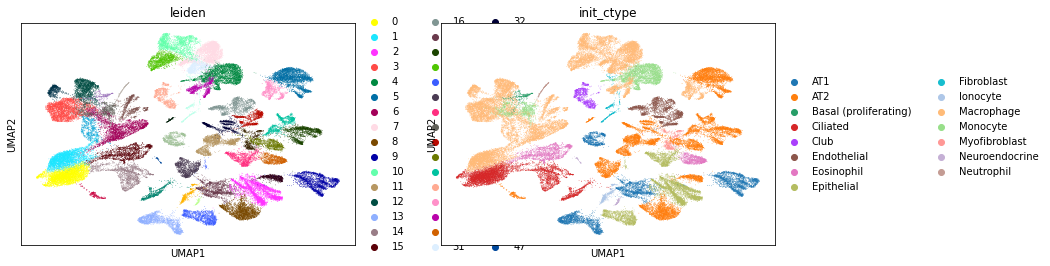


Clusters hard to identify
-------------------------
CPU times: user 1h 7min 27s, sys: 3min 25s, total: 1h 10min 53s
Wall time: 1h 4min 55s


In [6]:
%%time
results = pd.DataFrame()
fname = 'covid3balfs'

verbose = True
tic = time.time()
counter = 0
ORthreshold = 0.9
total_iter = len(cell_markers.keys())*len(x['cluster'].unique())
new_markers = {}
print('Lasso logistic regression')
for i,ctype in enumerate(cell_markers.keys()):
    for j,cluster in enumerate(x['cluster'].unique()):
        if verbose:
            if counter % 50 == 0 and counter != 0:
                p_through = counter / total_iter
                toc = time.time() - tic
                print('  through {:.1f}-% in {:.2f}-s\t~{:.2f}-s remain'.format(100*p_through,toc,(toc/counter)*(total_iter-counter)))
            
        # binarize & subset
        y = (x['cluster']==cluster).astype(int)
        if add_pcs:
            X = x.loc[:,cell_markers[ctype]+pcs]
        else:
            X = x.loc[:,cell_markers[ctype]]
        
        # run default params (could add CV)
        ## results, solver='saga', time for ~25k cells: >>1min
        ## results, solver='lbfgs', time for ~25k cells: 14s
        ## results, solver='liblinear', time for ~25k cells: 25s
        model = LogisticRegression(max_iter=10000, 
                                   penalty='l1',
                                   tol=1e-6,
                                   solver='liblinear') #n_jobs=-1 doesn't work for liblinear
        model.fit(X, y) 
        
        status = 'OK'
        if any(np.exp(model.coef_)[0][:-len(pcs)] < ORthreshold):
            markers = [marker for i,marker in enumerate(cell_markers[ctype]) if i not in np.where(np.exp(model.coef_)[0][:-len(pcs)]<0.9)[0]]
            if len(markers) != 0:
                new_markers[ctype] = markers
                if add_pcs:
                    X = x.loc[:,markers+pcs]
                else:
                    X = x.loc[:,markers]
                model = LogisticRegression(max_iter=10000, 
                                   penalty='l1',
                                   tol=1e-6,
                                   solver='liblinear') #n_jobs=-1 doesn't work for liblinear
                model.fit(X, y)
            else:
                status = 'No markers with ORs >= {}'.format(ORthreshold)
        else: 
            markers = cell_markers[ctype]
            
                
            
        
        p1 = model.predict_proba(X)[:,1]
        fpr, tpr, thresholds = metrics.roc_curve(y, p1)
        optimal_idx = np.argmax(tpr-fpr)
        optimal_threshold = thresholds[optimal_idx]
        optimal_pred = (p1>optimal_threshold).astype(int)
        precision,recall,_ = metrics.precision_recall_curve(y, p1)
        auprc = metrics.auc(recall, precision)
        auroc = metrics.roc_auc_score(y,p1)
        ap = metrics.average_precision_score(y,p1)
        bs = metrics.brier_score_loss(y,p1)
        acc = metrics.accuracy_score(y,optimal_pred)
        
        # store results
        dt = pd.DataFrame({'ctype2pred':ctype,
                           'cluster':cluster,
                           'auroc':auroc,
                           'status':status,
                           'markers':[markers],
                           'ORs':np.exp(model.coef_).tolist(),
                           'ave_prec':ap,
                           'acc':acc,
                           'sensitivity':tpr[optimal_idx],
                           'specificity':1-fpr[optimal_idx]},
                          index=[0])
        results = results.append(dt, ignore_index=True)
        counter += 1
print('Classifiers done. Saving and plotting...')  

top_per_ctype = pd.DataFrame()
top_n = 3
for ctype in results['ctype2pred'].unique():
    dt = results.loc[results['ctype2pred']==ctype,:]
    dt = dt.sort_values(by='auroc', ascending=False)
    top_per_ctype = top_per_ctype.append(dt.iloc[0:top_n,:], ignore_index=True)
    
top_per_cluster = pd.DataFrame()
top_n = 3
for cluster in results['cluster'].unique():
    dt = results.loc[results['cluster']==cluster,:]
    dt = dt.sort_values(by='auroc', ascending=False)
    top_per_cluster = top_per_cluster.append(dt.iloc[0:top_n,:], ignore_index=True)
    
if True:
    top_per_cluster.to_csv(os.path.join(pfp,'top_ctype_per_cluster_{}.csv'.format(fname)))
    
    
# plot init annotation
## taking top ctype per cluster
top1_per_cluster = pd.DataFrame()
for cluster in results['cluster'].unique():
    dt = results.loc[results['cluster']==cluster,:]
    dt = dt.sort_values(by='auroc', ascending=False)
    if True:
        # eliminate rows with poor status (no markers with OR>=threshold)
        dt = dt.loc[dt['status'] == 'OK',:]
    if dt.shape[0]==0:
        print('Cluster {} could not be annotated due to ORs of markers.'.format(cluster))
        continue
    top1_per_cluster = top1_per_cluster.append(dt.iloc[0:1,:], ignore_index=True)
ctype_annotation = {}
for cluster in top1_per_cluster['cluster']:
    ctype_annotation[cluster] = top1_per_cluster.loc[top1_per_cluster['cluster']==cluster,'ctype2pred'].values[0]
adata.obs['init_ctype'] = adata.obs['leiden'].astype(str)
adata.obs['init_ctype'] = adata.obs['init_ctype'].map(ctype_annotation)

## aesthetics
pal18=['#ee5264','#565656','#75a3b7','#ffe79e','#fac18a','#f1815f','#ac5861','#62354f','#2d284b','#f4b9b9','#c4bbaf',
               '#f9ebae','#aecef9','#aeb7f9','#f9aeae','#9c9583','#88bb92','#bde4a7','#d6e5e3']
cmap_ctype = {v:pal18[i] for i,v in enumerate(adata.obs['init_ctype'].unique())}

## plot
sc.pl.umap(adata, color=['leiden', 'init_ctype'])


if verbose:
    # print bad ones
    print('\nClusters hard to identify')
    print('-------------------------')
    
    underdetermined = top1_per_cluster.loc[top1_per_cluster['auroc'] <= 0.7, :]
    for i in range(underdetermined.shape[0]):
        print(underdetermined.iloc[i,:])
    

In [7]:
# save metadata
adata.obs.to_csv(os.path.join(pfp, 'metadata_{}'.format(datetime.datetime.now().strftime('%y%m%d'))))

In [8]:
pfp

'/home/ngr4/project/collabs/grants/czi_rp_2103/results/'

In [24]:
adata.obs['source_2'] = '(Ours)'
adata.obs.loc[adata.obs['source']=='LungMap', 'source_2'] = '(LMap)'

In [25]:
adata.obs['age_sex_source'] = adata.obs['age'].astype(str) + ', ' + adata.obs['sex'].astype(str) + ' ' + adata.obs['source_2'].astype(str)
adata.obs['age_sex_source'] = adata.obs['age_sex_source'].astype('category')

In [26]:
dt = adata.obs.groupby(['init_ctype', 'age_sex_source']).count().reset_index()

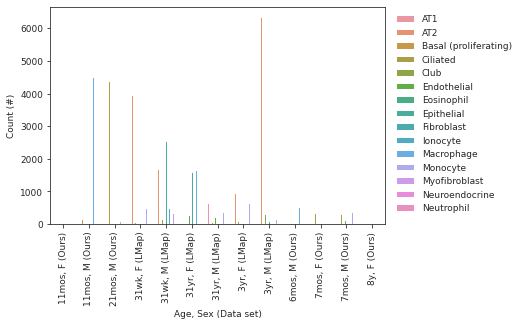

In [35]:
dt = adata.obs.groupby(['init_ctype', 'age_sex_source']).count().reset_index()
fig, ax = plt.subplots(1, 1)
sns.barplot(x='age_sex_source', y='age', 
            data=dt,
            ci=None,
            hue='init_ctype', 
            ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_xlabel('Age, Sex (Data set)')
ax.set_ylabel('Count (#)')
fig.savefig(os.path.join(pfp, 'barplot_ctypecount_per_dataset.png'), dpi=300, bbox_inches='tight')

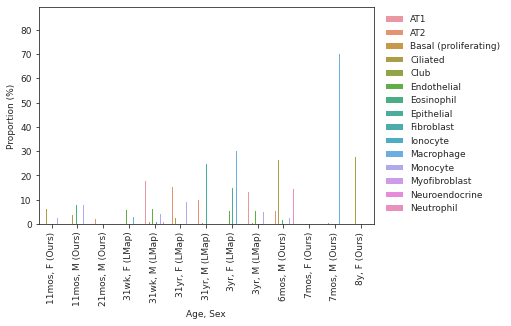

In [36]:
dt = 100*adata.obs.groupby(['init_ctype', 'age_sex_source']).count()['age']/adata.obs.groupby(['age_sex_source']).count()['age']
dt = dt.reset_index()
fig, ax = plt.subplots(1, 1)
sns.barplot(x='age_sex_source', y='age', 
            data=dt,
            ci=None,
            hue='init_ctype',
            ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend(bbox_to_anchor=(1.01, 1))
ax.set_xlabel('Age, Sex')
ax.set_ylabel('Proportion (%)')
fig.savefig(os.path.join(pfp, 'barplot_ctypepct_per_dataset.png'), dpi=300, bbox_inches='tight')